# Práctica 2 - Ejercicio 3: Predicción de Energía con Series Temporales Multivariantes

**Asignatura**: Machine Learning, 2025/2026

**Profesora**: Jose Tomas, Palma Mendez

**Máster de Inteligencia Artificial**
**Autores:**  
- Jesús Guirado Pérez  
- Antonio Luis Sánchez Torres  
- Víctor Emilio Vicente García

## Índice
1. [Introducción](#intro)
2. [Lectura y Preparación de Datos](#lectura)
3. [Modelo Línea Base](#linea-base)
4. [Estrategia de Evaluación](#eval)
5. [Modelos Avanzados con Grid Search](#modelos)
   1. [Random Forest](#random)
   2. [XGBoost](#xgboost)
   3. [SVR](#svr)
6. [Comparación y Conclusiones](#conclu)

 [Uso de IA Generativa](#genia)

 [Entorno de Ejecución](#entorno)

## Introducción <a class="anchor" id="intro"></a>

En este notebook vamos a realizar el ejercicio 2.3 de predicción de energía con series temporales multivariables. En terminos generales vamos a continuar con los mismos algoritmos y estrategias que en el ejercicio anterior pero con estrategias multivariables


## Lectura y Preparación de Datos <a class="anchor" id="lectura"></a>

En esta sección se cargan los datos previamente preprocesados y analizados en el notebook `practica2_ejercicio1.ipynb`

In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Skforecast para series temporales multivariantes
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries, grid_search_forecaster_multiseries

## Graficos
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# CONSTANTES
TARGET = 'Energía total (kWh)'
HORIZONTE = 7  # días
LAGS = 7
SEED = 42

# Configuraciones de lags basadas en estacionalidad semanal y mensual/anual
# Config 1: Lags estratégicos (semanal, mensual, semestral, anual)
lags_grid_estrategicos = [7, 30, 183, 365]

# Config 2: Lags diarios recientes + contexto anual
lags_grid_diarios_anuales = [[1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 365],
                             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                               359, 360, 361, 362, 363, 365, 366, 367, 368, 369, 370, 371, 372
                            ]]

# Grid completo para búsqueda
lags_grid = lags_grid_estrategicos + lags_grid_diarios_anuales

### Configuración de lags y estrategia de modelado

Dado que la serie temporal de energía ha demostrado ser **estacionaria** tras el análisis ADF (Augmented Dickey-Fuller) realizado en el ejercicio 1, se ha decidido **utilizar únicamente el método Recursivo** para el forecasting.

**Estrategia de lags:**

Se utilizarán dos configuraciones de lags basadas en los patrones identificados:

1. **Lags semanales y anuales**: `[7, 30, 183, 365]`
   - Lag 7: Captura el patrón semanal (7 días anteriores)
   - Lag 30: Captura el patrón mensual (1 mes anterior)
   - Lag 183: Captura el patrón semestral (6 meses anteriores)
   - Lag 365: Captura el patrón anual (año anterior)

2. **Lags diarios recientes + anuales**: `[1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 365]`
   - Lags 1-7: Semana completa anterior (captura tendencias recientes)
   - Lags 359-365: Días cercanos al mismo período del año anterior (captura estacionalidad anual)
   - Mantenemos un número reducido de lags (14) mientras capturamos tendencia reciente y estacionalidad anual.


In [2]:
# Cargar datos
energia_preprocesada = pd.read_csv('energia_preprocesada.csv', index_col=0, parse_dates=True)
# Establecer frecuencia diaria
energia_preprocesada = energia_preprocesada.asfreq('D')
energia_preprocesada = energia_preprocesada.drop(columns="Día de la semana")

# Eliminar la columna 'Emisión (kg CO₂)' ya que está correlacionada al 100% con 'Energía total (kWh)'

# Esto reduce el tamaño del dataset y acelera el entrenamiento sin pérdida de informaciónprint(f"Shape: {energia_preprocesada.shape}")

if 'Emisión (kg CO₂)' in energia_preprocesada.columns:
    print(f"\nColumnas finales: {list(energia_preprocesada.columns)}")

    energia_preprocesada = energia_preprocesada.drop('Emisión (kg CO₂)', axis=1)
    display(energia_preprocesada.head())

    print("✓ Columna 'Emisión (kg CO₂)' eliminada (correlación 100% con energía)")


Columnas finales: ['Electricidad (kW)', 'Fotovoltaica (kW)', 'Refrigeración (kW)', 'Calefacción (kWh)', 'Energía total (kWh)', 'Emisión (kg CO₂)']


,Electricidad (kW),Fotovoltaica (kW),Refrigeración (kW),Calefacción (kWh),Energía total (kWh)
2014-01-01,490049.28,62795.47,243369.71770,20107.60131,753526.59901
2014-01-02,556486.56,64284.00,323886.05169,23987.86135,904360.47304
2014-01-03,545831.45,67187.06,337004.60237,22112.20695,904948.25932
2014-01-04,511495.56,46798.28,252493.06189,21074.73561,785063.35750
2014-01-05,502806.80,70162.87,249265.37031,22777.47812,774849.64843


✓ Columna 'Emisión (kg CO₂)' eliminada (correlación 100% con energía)


Vamos a dividir el dataset en train y test, para ello hemos elegido la estrategia de hold out con 80, 20 ya que es estandar en la industria. Además es la misma estrategía que utilizamos en el ejercicio 2.

In [3]:
# División train/test 80/20
train_index = int(len(energia_preprocesada) * 0.8)
train_data = energia_preprocesada.iloc[:train_index]
train_data = train_data.asfreq('D')
test_data = energia_preprocesada.iloc[train_index:]
test_data = test_data.asfreq('D')


### Creamos la variable exogena de dayofweek

In [4]:
# Crear variable exógena: día de la semana
exog_train = pd.DataFrame({
    'dia_semana': train_data.index.dayofweek
}, index=train_data.index)

exog_test = pd.DataFrame({
    'dia_semana': test_data.index.dayofweek
}, index=test_data.index)

# Para backtesting, necesitamos exog para todo el conjunto de datos
exog_completo = pd.DataFrame({
    'dia_semana': energia_preprocesada.index.dayofweek
}, index=energia_preprocesada.index)

print("Variables exógenas creadas:")
print(f"  • dia_semana: valores de 0 (lunes) a 6 (domingo)")
display(exog_train.head(10))

Variables exógenas creadas:
  • dia_semana: valores de 0 (lunes) a 6 (domingo)


,dia_semana
2014-01-01,2
2014-01-02,3
2014-01-03,4
2014-01-04,5
2014-01-05,6
2014-01-06,0
2014-01-07,1
2014-01-08,2
2014-01-09,3
2014-01-10,4


### Crear Variables Exógenas

Vamos a crear el día de la semana como variable exógena, que puede ayudar a capturar patrones semanales en el consumo de energía.

Vamos a representar las distintas variables en una gráfica con la partición de train y test.

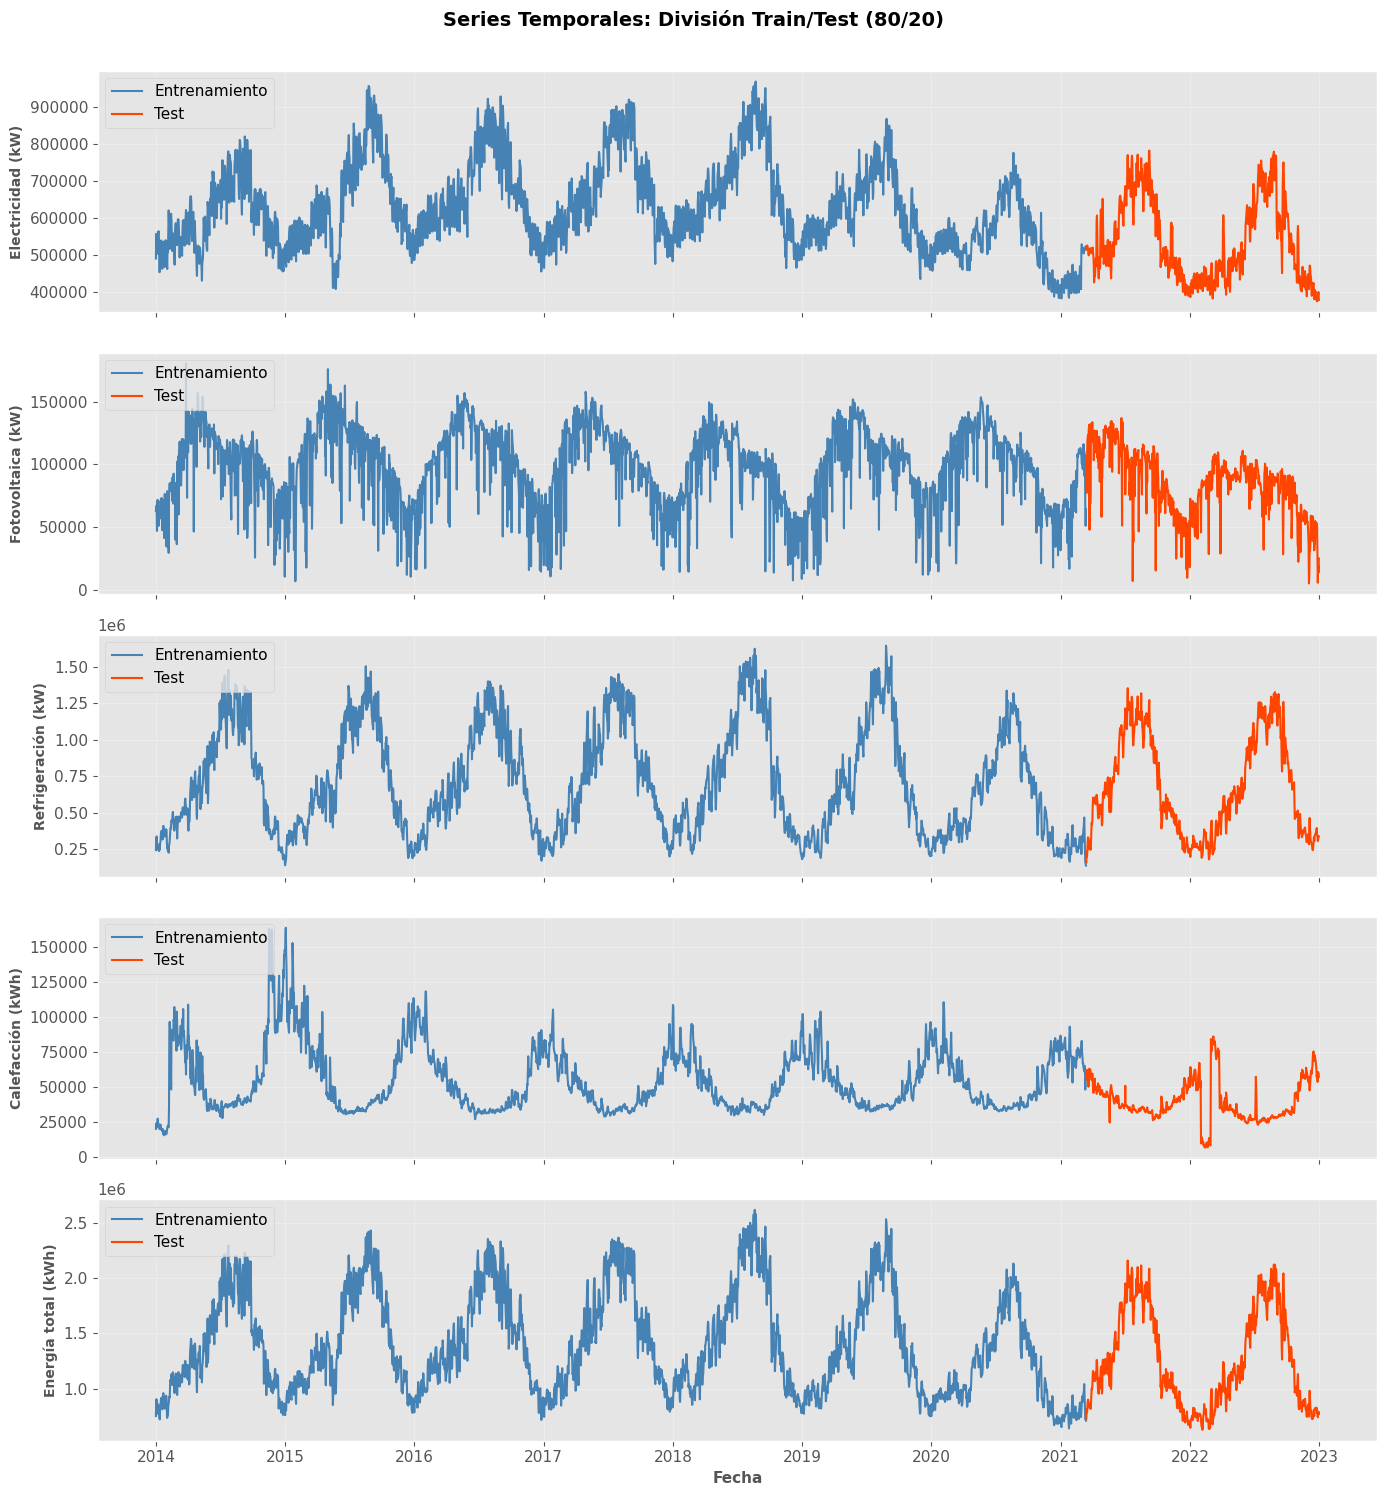

In [5]:
# Visualización de la división train/test
n_series = len(energia_preprocesada.columns)
fig, axes = plt.subplots(n_series, 1, figsize=(14, 3*n_series), sharex=True)

if n_series == 1:
    axes = [axes]

for i, col in enumerate(energia_preprocesada.columns):
    ax = axes[i]
    ax.plot(train_data.index, train_data[col], color='steelblue', label='Entrenamiento', linewidth=1.5)
    ax.plot(test_data.index, test_data[col], color='orangered', label='Test', linewidth=1.5)
    ax.set_ylabel(col, fontsize=10, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Fecha', fontsize=11, fontweight='bold')
fig.suptitle('Series Temporales: División Train/Test (80/20)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

## 2. Modelo Línea Base <a class="anchor" id="linea-base"></a>

Vamos a utilizar un **modelo baseline simple** basado en la media entre:
- El **día anterior** (lag 1)
- El **mismo día del año anterior** (lag 365)

Esta estrategia captura tanto la tendencia reciente como la estacionalidad anual de forma simple y computacionalmente eficiente.

**Estrategia para horizonte de 7 días:**
- **h=1**: Predicción = media(último_día_train, mismo_día_año_anterior)
- **h=2**: Predicción = media(predicción_h1, día_año_anterior_correspondiente)
- **h=3 a h=7**: Se continúa usando la predicción anterior y el día del año anterior correspondiente

Este modelo es extremadamente simple pero efectivo para series con fuerte estacionalidad anual, y servirá como referencia para comparar con modelos más complejos.

In [6]:
# Función para crear predicciones baseline con media de día anterior + mismo día año anterior
def crear_baseline_predicciones(train_data, target_column, horizonte=7):
    predicciones = []
    fechas_pred = []
    
    # Obtener el último valor de train y su índice
    ultimo_idx_train = train_data.index[-1]
    ultimo_valor = train_data[target_column].iloc[-1]
    
    for h in range(1, horizonte + 1):
        # Fecha de la predicción
        fecha_pred = ultimo_idx_train + pd.Timedelta(days=h)
        fechas_pred.append(fecha_pred)
        
        # Fecha del mismo día del año anterior
        fecha_año_anterior = fecha_pred - pd.Timedelta(days=365)
        
        idx_cercano = train_data.index.get_indexer([fecha_año_anterior], method='nearest')[0]
        valor_año_anterior = train_data[target_column].iloc[idx_cercano]
        
        # Para h=1, usar el último día de train
        # Para h>1, usar la predicción anterior
        if h == 1:
            valor_anterior = ultimo_valor
        else:
            valor_anterior = predicciones[-1]
        
        # Predicción como media simple
        pred = (valor_anterior + valor_año_anterior) / 2
        predicciones.append(pred)
    
    # Crear serie con las predicciones
    predicciones_serie = pd.Series(predicciones, index=fechas_pred, name='pred')
    
    return predicciones_serie

# Crear predicciones baseline
prediccion_inicial = crear_baseline_predicciones(train_data, TARGET, HORIZONTE)

# Convertir a DataFrame para mantener consistencia con código posterior
prediccion_inicial = pd.DataFrame(prediccion_inicial)

Vamos a visualizar los primeros 7 días predichos con el modelo baseline simple comparándolos con los valores reales.

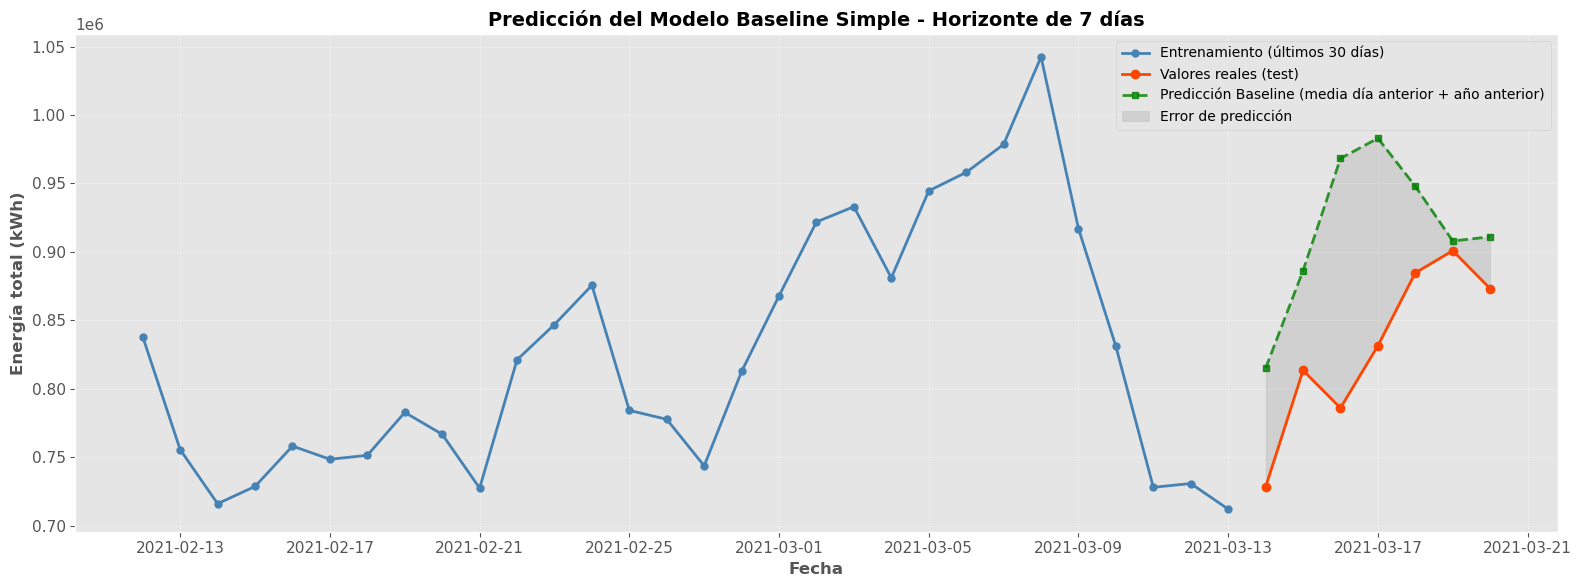

In [7]:
# Visualizar la predicción del modelo baseline
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar últimos 30 días de entrenamiento
ultimos_dias_train = train_data[TARGET].iloc[-30:]
ax.plot(ultimos_dias_train.index, ultimos_dias_train, 
        'o-', color='steelblue', label='Entrenamiento (últimos 30 días)', 
        linewidth=2, markersize=5)

# Mostrar primeros 7 días de test (valores reales)
primeros_dias_test = test_data[TARGET].iloc[:HORIZONTE]
ax.plot(primeros_dias_test.index, primeros_dias_test, 
        'o-', color='orangered', label='Valores reales (test)', 
        linewidth=2, markersize=6)

# Mostrar predicción del baseline
ax.plot(prediccion_inicial.index, prediccion_inicial['pred'], 
        's--', color='green', label='Predicción Baseline (media día anterior + año anterior)', 
        linewidth=2, markersize=5, alpha=0.8)

# Área sombreada para el error
ax.fill_between(primeros_dias_test.index, 
                primeros_dias_test, 
                prediccion_inicial['pred'],
                alpha=0.2, color='gray', label='Error de predicción')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía total (kWh)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicción del Modelo Baseline Simple - Horizonte de {HORIZONTE} días', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Se puede ver que los resultados son buenos para los primeros 2 días y despues se produce una desviación de más intensas en el tercer, quinto, sexto y septimo día.

## Estrategia de Evaluación <a class="anchor" id="eval"></a>

Para la evaluación vamos a utilziar las mismas métricas que utilizamos en el notebook anterior, MAE, RMSE, RMSSE y MAPE. Estas métricas las utilizaremos con el conjunto de Train con Backtesting y para comprobar la generalización y overfiting del modelo utilizaremos una función para calcular los errores por cada día del horizonte.

In [8]:
# Función para calcular métricas de evaluación
def calcular_metricas(y_true, y_pred, nombre_modelo="Modelo", verbose=True):
    """
    Calcula métricas de evaluación para predicciones de series temporales.
    
    Métricas:
    - MAE: Mean Absolute Error
    - RMSE: Root Mean Squared Error
    - RMSSE: Root Mean Squared Scaled Error
    - MAPE: Mean Absolute Percentage Error
    """
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    # RMSE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # RMSSE (Root Mean Squared Scaled Error)
    # Escala usando las diferencias consecutivas de la serie real
    scale = np.mean(np.diff(y_true)**2)
    rmsse = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
    
    # MAPE (Mean Absolute Percentage Error)
    # Evitar división por cero
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.inf
    
    resultados = {
        'Modelo': nombre_modelo,
        'MAE': mae,
        'RMSE': rmse,
        'RMSSE': rmsse,
        'MAPE': mape
    }
    
    if verbose:
        print(f"\nMétricas de {nombre_modelo}:")
        print(f"  • MAE   = {mae:.3f} kWh")
        print(f"  • RMSE  = {rmse:.3f} kWh")
        print(f"  • RMSSE = {rmsse:.4f}")
        print(f"  • MAPE  = {mape:.2f}%")
    
    return resultados

In [38]:
def calcular_errores_por_horizonte(modelo, test_data, train_data=None, offset_lags=0, exog_test=None, horizonte=7, target_col='Energía total (kWh)', verbose=True):
    # Si se proporcionan datos de train, concatenarlos con test para tener suficientes lags
    if train_data is not None:
        # Concatenar últimos 365 días de train con test
        datos_completos = pd.concat([train_data.tail(offset_lags), test_data])
        # Ajustar índice de inicio
        offset = offset_lags
    else:
        datos_completos = test_data
        offset = 0
    
    # Inicializar listas para almacenar errores
    errores_por_ventana = []
    predicciones_lista = []
    
    # Calcular cuántas ventanas de predicción podemos hacer
    n_ventanas = len(test_data) - horizonte + 1
    
    # Para cada ventana de inicio en el conjunto de test
    for i in range(n_ventanas):
        # Índice en test_data
        idx_test = i
        # Índice en datos_completos
        idx_completo = i + offset
        
        # Fecha de inicio de la predicción
        fecha_inicio = test_data.index[idx_test]
        
        # Realizar predicción para los próximos 'horizonte' días
        # Datos hasta el punto de predicción (incluye train si está disponible)
        datos_hasta_punto = datos_completos.iloc[:idx_completo]
        
        if  exog_test is not None:
            # Variables exógenas para el periodo de predicción
            exog_periodo = exog_test.iloc[idx_test:idx_test+horizonte]
            pred = modelo.predict(steps=horizonte, levels=target_col, 
                                 last_window=datos_hasta_punto, exog=exog_periodo)
        else:
            pred = modelo.predict(steps=horizonte, levels=target_col,
                                 last_window=datos_hasta_punto)
        
        # Obtener valores reales para este periodo
        y_true = test_data[target_col].iloc[idx_test:idx_test+horizonte].values
        
        # Extraer predicciones solo para la serie objetivo
        # pred puede ser un DataFrame con múltiples series
        y_pred = pred['pred']

        # Asegurarse de que las dimensiones coinciden
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
        # Calcular error absoluto para cada día del horizonte
        errores_ventana = np.abs(y_true - y_pred)
        
       # Calcular errores
        error_abs = np.abs(y_true - y_pred)
        error_squared = (y_true - y_pred) ** 2
        error_pct = np.abs((y_true - y_pred) / y_true) * 100
        
        # Guardar predicciones
        for h in range(min_len):
            predicciones_lista.append({
                'ventana': i,
                'fecha_inicio': fecha_inicio,
                'horizonte_dia': h + 1,
                'fecha_pred': test_data.index[idx_test + h],
                'valor_real': float(y_true[h]),
                'valor_pred': float(y_pred[h]),
                'error_absoluto': float(error_abs[h]),
                'error_cuadrado': float(error_squared[h]),
                'error_porcentual': float(error_pct[h])
            })
        
        # Guardar errores de esta ventana
        errores_ventana_dict = {'ventana': i, 'fecha_inicio': fecha_inicio}
        for h in range(min_len):
            errores_ventana_dict[f'mae_h{h+1}'] = float(error_abs[h])
            errores_ventana_dict[f'mse_h{h+1}'] = float(error_squared[h])
            errores_ventana_dict[f'mape_h{h+1}'] = float(error_pct[h])
        
        errores_por_ventana.append(errores_ventana_dict)
    
    # Crear DataFrames
    df_errores = pd.DataFrame(errores_por_ventana)
    df_predicciones = pd.DataFrame(predicciones_lista)
    
    if len(df_predicciones) == 0:
        print("\n⚠ No se pudieron generar predicciones. Verifica los datos y el modelo.")
        return None
    
    # Calcular métricas por horizonte
    metricas_por_h = []
    for h in range(1, horizonte + 1):
        # Filtrar predicciones para este horizonte
        pred_h = df_predicciones[df_predicciones['horizonte_dia'] == h]
        
        y_true_h = pred_h['valor_real'].values
        y_pred_h = pred_h['valor_pred'].values
        
        # MAE
        mae = np.mean(np.abs(y_true_h - y_pred_h))
        
        # RMSE
        mse = np.mean((y_true_h - y_pred_h) ** 2)
        rmse = np.sqrt(mse)
        
        # RMSSE (Root Mean Squared Scaled Error)
        scale = np.mean(np.diff(y_true_h)**2) if len(y_true_h) > 1 else 1
        rmsse = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
        
        # MAPE
        mask = y_true_h != 0
        mape = np.mean(np.abs((y_true_h[mask] - y_pred_h[mask]) / y_true_h[mask])) * 100 if mask.sum() > 0 else np.inf
        
        metricas_por_h.append({
            'Horizonte': f'h+{h}',
            'MAE': mae,
            'RMSE': rmse,
            'RMSSE': rmsse,
            'MAPE': mape
        })
    
    df_metricas = pd.DataFrame(metricas_por_h)
    
    # Calcular métricas globales (promedio de todos los horizontes)
    metricas_globales = {
        'MAE': df_metricas['MAE'].mean(),
        'RMSE': df_metricas['RMSE'].mean(),
        'RMSSE': df_metricas['RMSSE'].mean(),
        'MAPE': df_metricas['MAPE'].mean()
    }

    return {
        'metricas_por_horizonte': df_metricas,
        'metricas_globales': metricas_globales,
        'errores_detallados': df_errores,
        'predicciones': df_predicciones
    }

def visualizar_errores_horizonte(resultados, titulo="Análisis de Errores por Horizonte"):
    """
    Visualiza los errores por horizonte de predicción con múltiples métricas
    y gráficas de predicciones vs valores reales para cada horizonte.
    
    Parámetros:
    -----------
    resultados : dict
        Diccionario retornado por calcular_errores_por_horizonte
    titulo : str
        Título general de las visualizaciones
    """
    df_metricas = resultados['metricas_por_horizonte']
    df_predicciones = resultados['predicciones']
    
    # PARTE 1: Gráficas de métricas por horizonte
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    metricas = ['MAE', 'RMSE', 'RMSSE', 'MAPE']
    ylabels = ['MAE (kWh)', 'RMSE (kWh)', 'RMSSE', 'MAPE (%)']
    colors = ['steelblue', 'darkorange', 'green', 'crimson']
    
    for idx, (metrica, ylabel, color) in enumerate(zip(metricas, ylabels, colors)):
        ax = axes[idx // 2, idx % 2]
        
        x = range(1, len(df_metricas) + 1)
        y = df_metricas[metrica].values
        
        # Barras
        ax.bar(x, y, color=color, alpha=0.7, edgecolor='black')
        
        # Línea de tendencia
        ax.plot(x, y, 'o-', color=color, linewidth=2, markersize=8, alpha=0.9)
        
        ax.set_xlabel('Horizonte de Predicción', fontsize=11, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=11, fontweight='bold')
        ax.set_title(f'{metrica} por Horizonte', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([f'h+{i}' for i in x])
        ax.grid(axis='y', alpha=0.3)
        
        # Valores sobre las barras
        for i, val in enumerate(y):
            format_str = f'{val:.0f}' if metrica in ['MAE', 'RMSE'] else f'{val:.3f}'
            ax.text(i + 1, val, format_str, ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')
    
    plt.suptitle(f'{titulo} - Métricas de Error', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # PARTE 2: Gráficas de predicciones vs valores reales para cada horizonte
    n_horizontes = df_predicciones['horizonte_dia'].nunique()
    fig, axes = plt.subplots(n_horizontes, 1, figsize=(16, 4 * n_horizontes))
    
    if n_horizontes == 1:
        axes = [axes]
    
    for h in range(1, n_horizontes + 1):
        ax = axes[h - 1]
        
        # Filtrar datos para este horizonte
        datos_h = df_predicciones[df_predicciones['horizonte_dia'] == h].sort_values('fecha_pred')
        
        # Plotear valores reales y predichos
        ax.plot(datos_h['fecha_pred'], datos_h['valor_real'], 
               'o-', color='steelblue', label='Valores Reales', 
               linewidth=2, markersize=4, alpha=0.8)
        
        ax.plot(datos_h['fecha_pred'], datos_h['valor_pred'], 
               's--', color='orangered', label='Predicciones', 
               linewidth=2, markersize=4, alpha=0.8)
        
        # Área de error
        ax.fill_between(datos_h['fecha_pred'], 
                        datos_h['valor_real'], 
                        datos_h['valor_pred'],
                        alpha=0.2, color='gray')
        
        # Métricas para este horizonte
        metrica_h = df_metricas[df_metricas['Horizonte'] == f'h+{h}'].iloc[0]
        texto_metricas = (f"MAE: {metrica_h['MAE']:.2f} | "
                         f"RMSE: {metrica_h['RMSE']:.2f} | "
                         f"RMSSE: {metrica_h['RMSSE']:.4f} | "
                         f"MAPE: {metrica_h['MAPE']:.2f}%")
        
        ax.set_xlabel('Fecha', fontsize=11, fontweight='bold')
        ax.set_ylabel('Energía (kWh)', fontsize=11, fontweight='bold')
        ax.set_title(f'Horizonte h+{h} - {texto_metricas}', 
                    fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Rotar etiquetas de fecha si hay muchos puntos
        if len(datos_h) > 30:
            ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'{titulo} - Predicciones por Horizonte', 
                fontsize=14, fontweight='bold', y=0.9995)
    plt.tight_layout()
    plt.show()

La función anterior genera las métricas MAE, RMSE, RMSSE y MAPE para comparar valores reales y predichos.

**Interpretación de las métricas:**
- **MAE** (Mean Absolute Error): Error absoluto medio en kWh. Más bajo es mejor.
- **RMSE** (Root Mean Squared Error): Penaliza más los errores grandes. Más bajo es mejor.
- **RMSSE** (Root Mean Squared Scaled Error): RMSE normalizado por la variabilidad de la serie.
- **MAPE** (Mean Absolute Percentage Error): Error porcentual medio. Más bajo es mejor.

### Estrategia de Evaluación con TimeSeriesFold:
El objeto TimeSeriesFold sería realizar una validación cruzada sobre el conjunto de train, con esto podrémos controlar el overfitting, hemos elegido que comience con un año de datos iniciales de 3 años y que tenga una ventana de un año.

In [10]:
initial_train_size = 365*3  # díasç
window_size = 365
# Crear TimeSeriesFold para backtesting
cv = TimeSeriesFold(
    steps=HORIZONTE,                  # Horizonte de predicción
    initial_train_size=initial_train_size,  # Inicial de 365 días
    window_size=window_size,                 # Ventana fija de 7 días
    fold_stride           = None,
    refit=False,                      # No reentrenar en cada fold
    fixed_train_size=True,           # Ventana fija
    gap=0,                            # Sin gap entre train y test
    allow_incomplete_fold=True,       # Permitir folds incompletos
)
cv.split(X=train_data, as_pandas=True)

Information of folds
--------------------
Number of observations used for initial training: 1095
Number of observations used for backtesting: 1534
    Number of folds: 220
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-30 00:00:00  (n=1095)
    Validation: 2016-12-31 00:00:00 -- 2017-01-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-01-07 00:00:00 -- 2017-01-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2017-01-14 00:00:00 -- 2017-01-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-01-21 00:00:00 -- 2017-01-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2017-01-28 00:00:00 -- 2017-02-03 00:00:00  (n=7)
Fold: 5
    Training: 

,fold,train_start,train_end,last_window_start,last_window_end,test_start,test_end,test_start_with_gap,test_end_with_gap,fit_forecaster
0,0,0,1095,730,1095,1095,1102,1095,1102,True
1,1,0,1095,737,1102,1102,1109,1102,1109,False
2,2,0,1095,744,1109,1109,1116,1109,1116,False
3,3,0,1095,751,1116,1116,1123,1116,1123,False
4,4,0,1095,758,1123,1123,1130,1123,1130,False
...,...,...,...,...,...,...,...,...,...,...
215,215,0,1095,2235,2600,2600,2607,2600,2607,False
216,216,0,1095,2242,2607,2607,2614,2607,2614,False
217,217,0,1095,2249,2614,2614,2621,2614,2621,False
218,218,0,1095,2256,2621,2621,2628,2621,2628,False


In [ ]:
# Función para evaluar el baseline simple en un conjunto de datos
def evaluar_baseline_simple(datos, target_col,verbose=True, nombre_conjunto="datos"):
    """
    Evalúa el modelo baseline simple en un conjunto de datos completo.
    Para cada punto, predice usando la media del día anterior y el mismo día del año anterior.
    """
    predicciones = []
    valores_reales = []
    
    # Necesitamos al menos 365 días para poder usar el año anterior
    inicio = 365
    if verbose:
        print(f"\nEvaluando baseline en {nombre_conjunto}...")
        print(f"  Rango: desde índice {inicio} hasta {len(datos)}")
    
    for i in range(inicio, len(datos)):
        # Valor real
        valor_real = datos[target_col].iloc[i]
        valores_reales.append(valor_real)
        
        # Día anterior (lag 1)
        valor_dia_anterior = datos[target_col].iloc[i-1]
        
        # Mismo día del año anterior (lag 365)
        valor_año_anterior = datos[target_col].iloc[i-365]
        
        # Predicción como media simple
        pred = (valor_dia_anterior + valor_año_anterior) / 2
        predicciones.append(pred)
    
    y_true = np.array(valores_reales)
    y_pred = np.array(predicciones)
    
    if verbose:
        print(f"  Total de predicciones: {len(predicciones)}")
    
    return y_true, y_pred

# 1. Evaluar en TRAIN
y_true_train, y_pred_train = evaluar_baseline_simple(
    datos=train_data,
    target_col=TARGET,
    nombre_conjunto="TRAIN"
)

metricas_baseline_train = calcular_metricas(
    y_true_train, 
    y_pred_train, 
    "Baseline Simple - TRAIN"
)

# 2. Evaluar en TEST
y_true_test, y_pred_test = evaluar_baseline_simple(
    #Metemos el último año de train para poder predecir los dos primeros de test
    #ya que nuestro modelo usa el valor del mismo día delaño anterior
    datos=pd.concat([train_data[-365:], test_data]),
    target_col=TARGET,
    nombre_conjunto="TEST"
)

metricas_baseline_test = calcular_metricas(
    y_true_test, 
    y_pred_test, 
    "Baseline Simple - TEST"
)

# Guardar resultados para comparación posterior
resultados_modelos_cv = [metricas_baseline_train, metricas_baseline_test]


Evaluando baseline en TRAIN...
  Rango: desde índice 365 hasta 2629
  Total de predicciones: 2264

Métricas de Baseline Simple - TRAIN:
  • MAE   = 107065.921 kWh
  • RMSE  = 139418.575 kWh
  • RMSSE = 1.3584
  • MAPE  = 7.82%

Evaluando baseline en TEST...
  Rango: desde índice 365 hasta 1023
  Total de predicciones: 658

Métricas de Baseline Simple - TEST:
  • MAE   = 78787.298 kWh
  • RMSE  = 103190.516 kWh
  • RMSSE = 1.3151
  • MAPE  = 6.41%


Podemos ver que el modelo base line realiza un total de 2264 predicciones en train y 658 en test. Las métricas obtenidas en train son peores que las obtenidas en test por lo que podemos decir que nuestro modelo naive se ajusta mejor al conjunto de test que al de train, podemos destacar la métrica de MAPE de 7.82% en train y 6.41% en test

## Modelos Avanzados con Grid Search <a class="anchor" id="modelos"></a>

En esta sección entrenamos tres modelos más avanzados mediante búsqueda de hiperparámetros, los mismos 3 modelos que usamos en el notebook anterior:

- **Random Forest**: Ensemble de árboles de decisión, robusto y efectivo
- **XGBoost**: Gradient boosting optimizado, muy potente en competiciones
- **SVR**: Support Vector Regression, captura relaciones no lineales



### Random Forest con Grid Search <a class="anchor" id="random"></a>

Vamos a comparar dos estrategias de forecasting:
- **Recursivo**: Usa predicciones previas iterativamente
- **Directo**: Entrena un modelo independiente para cada horizonte

Vamos a utilizar en Random Forest los siguientes parametros:

`n_estimators`: 50, 150

`max_depth`: 10, 20

`min_samples_split`: 2, 5

`min_samples_leaf`: 1, 2

Vamos a probar parámetros pequeños para no sobre ajustar demasiado, hay que tener en cuenta que el modelo utilizará todos los lags como variables para predecir.

#### Random Forest Recursivo

Podemos ver que los mejores parámetros han sido: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150} salvo para n_estimators los valores más bajos han dado mejores resultados. Se podría probar en el futuro añadir más n_estimators para ver si mejora el resultado con más arboles

In [12]:
# Crear forecaster recursivo
rf_forecaster = ForecasterRecursiveMultiSeries(
    regressor=RandomForestRegressor(random_state=SEED, n_jobs=-1),
    lags=LAGS,
    transformer_series=None,
    transformer_exog=None,
)
rf_forecaster


============================== 
ForecasterRecursiveMultiSeries 
============================== 
Estimator: RandomForestRegressor 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 7 
Series encoding: ordinal 
Series names (levels): None 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Estimator parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-12-20 20:24:11 
Last fit date: None 
Skforecast version: 0.19.1 
Python version: 3.11.7 
Forecaster id: None

In [13]:
# Definir grilla de hiperparámetros
param_grid_rf = {
    'n_estimators': [50,150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_rf = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}


# Ejecutar grid search con cv específico para validación interna
results_rf = grid_search_forecaster_multiseries(
    forecaster=rf_forecaster,
    series=train_data,
    exog=exog_train,
    param_grid=param_grid_rf,
    lags_grid=lags_grid,
    cv=cv,  
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7 359 360 361 362 363 365] 
  Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
  Backtesting metric: 51053.31675422446
  Levels: ['Electricidad (kW)', 'Fotovoltaica (kW)', 'Refrigeración (kW)', 'Calefacción (kWh)', 'Energía total (kWh)']



In [14]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_rf, predicciones_bt_rf = backtesting_forecaster_multiseries(
    forecaster=rf_forecaster,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)
y_true_bt_rf = train_data[TARGET].iloc[initial_train_size:]  # Ajustar índice para el backtesting
y_pred_bt_rf = predicciones_bt_rf['pred']
metricas_rf = calcular_metricas(
    y_true_bt_rf,
    y_pred_bt_rf,
    nombre_modelo="Random Forest - Backtesting"
)
resultados_modelos_cv.append(metricas_rf)

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de Random Forest - Backtesting:
  • MAE   = 117708.463 kWh
  • RMSE  = 156408.020 kWh
  • RMSSE = 1.6027
  • MAPE  = 8.78%


In [15]:
rf_forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Estimator: RandomForestRegressor 
Lags: [  1   2   3   4   5   6   7 359 360 361 362 363 365] 
Window features: None 
Window size: 365 
Series encoding: ordinal 
Series names (levels): 
    Electricidad (kW), Fotovoltaica (kW), Refrigeración (kW), Calefacción (kWh),
    Energía total (kWh) 
Exogenous included: True 
Exogenous names: dia_semana 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'Electricidad (kW)': ['2014-01-01', '2021-03-13'], 'Fotovoltaica (kW)':
    ['2014-01-01', '2021-03-13'], 'Refrigeración (kW)': ['2014-01-01',
    '2021-03-13'], 'Calefacción (kWh)': ['2014-01-01', '2021-03-13'], 'Energía
    total (kWh)': ['2014-01-01', '2021-03-13'] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50,
    'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-12-20 20:24:11 
Last fit date: 2025-12-20 20:25:24 
Skforecast version: 0.19.1 
Python version: 3.11.7 
Forecaster id: None

In [16]:
# Análisis de importancia de lags para Random Forest
import matplotlib.pyplot as plt
import pandas as pd

importance_df =rf_forecaster.get_feature_importances().sort_values(ascending=False, by='importance')
importance_df['importance'] = importance_df['importance'] * 100

print(importance_df.head(20).to_string(
    formatters={'importance': '{:.2f}%'.format}
))

              feature importance
0               lag_1     99.21%
14         dia_semana      0.29%
6               lag_7      0.07%
1               lag_2      0.06%
5               lag_6      0.06%
11            lag_363      0.06%
12            lag_365      0.04%
2               lag_3      0.04%
4               lag_5      0.03%
3               lag_4      0.03%
7             lag_359      0.02%
9             lag_361      0.02%
8             lag_360      0.02%
10            lag_362      0.02%
13  _level_skforecast      0.01%


In [ ]:
resultados_rf = calcular_errores_por_horizonte(
    modelo=rf_forecaster,
    test_data=test_data,
    train_data=train_data,  # Añadir esto para tener suficientes lags
    offset_lags=max(rf_forecaster.lags),
    exog_test=exog_test,
    horizonte=HORIZONTE,
    target_col=TARGET,
    verbose=True
)
visualizar_errores_horizonte(resultados_rf, titulo="Random Forest - Errores por Horizonte")

In [35]:
resultados_rf['errores_detallados']

,ventana,fecha_inicio,h+1,h+2,h+3,h+4,h+5,h+6,h+7
0,0,2021-03-14,4172.812529,9348.826429,47338.331697,16376.627521,33313.315323,64027.854126,72757.606936
1,1,2021-03-15,5081.450685,49387.082861,16376.627521,33313.315323,64027.854126,72757.606936,98925.331928
2,2,2021-03-16,56158.830856,15944.762778,37200.675179,66417.014074,72757.606936,99096.270769,3128.045317
3,3,2021-03-17,38044.037218,101178.723585,119560.696005,112059.560779,123038.491254,34870.207804,11782.565785
4,4,2021-03-18,36172.197270,60493.348969,72936.449987,99096.270769,31.132738,37438.836618,27002.301380
...,...,...,...,...,...,...,...,...,...
647,647,2022-12-21,11477.639847,7399.284641,12376.575737,33179.751611,72236.858988,50839.113150,57696.175345
648,648,2022-12-22,1671.954219,11599.483683,36251.383215,72236.858988,50705.404870,57696.175345,96363.781382
649,649,2022-12-23,10470.677344,40138.706752,80714.408834,34651.794957,39895.821895,87992.988699,67409.953587
650,650,2022-12-24,49745.448911,92144.339629,8804.371567,5864.623650,42457.033762,15497.720304,15782.705538


### XGBoost con Grid Search <a class="anchor" id="xgboost"></a>

Para XGBoost vamos a usar los siguientes parámetros:

`n_estimators`: 50, 100

`max_depth`: 3, 10

`learning_rate`: 0.01, 0.1

`subsample`: 0.8, 1.0

`colsample_bytree`: 0.8, 1.0

#### XGBoost Recursivo

In [ ]:
# Crear forecaster recursivo
xgb_forecaster = ForecasterRecursiveMultiSeries(
    regressor=XGBRegressor(random_state=SEED, n_jobs=-1, verbosity=0),
    lags=LAGS,
    transformer_series=None,
    transformer_exog=None,
)

# Definir grilla de hiperparámetros
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 10, 15],
    'learning_rate': [0.01,0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [5],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}



# Ejecutar grid search con cv específico para validación interna
results_xgb = grid_search_forecaster_multiseries(
    forecaster=xgb_forecaster,
    param_grid=param_grid_xgb,
    lags_grid=lags_grid,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=True,
    show_progress=True
)


5 models compared for 1 level(s). Number of iterations: 5.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

Information of folds
--------------------
Number of observations used for initial training: 1095
Number of observations used for backtesting: 1534
    Number of folds: 220
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-30 00:00:00  (n=1095)
    Validation: 2016-12-31 00:00:00 -- 2017-01-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-01-07 00:00:00 -- 2017-01-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2017-01-14 00:00:00 -- 2017-01-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-01-21 00:00:00 -- 2017-01-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2017-01-28 00:00:00 -- 2017-02-03 00:00:00  (n=7)
Fold: 5
    Training: 

Para XGBoost los mejores parámetros han sido  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}. Un mayor learning rate y numero de estimadores ha dado mejores resultados.

In [ ]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_xgb, predicciones_bt_xgb = backtesting_forecaster_multiseries(
    forecaster=xgb_forecaster,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)
y_true_bt_xgb = train_data[TARGET].iloc[initial_train_size:]  # Ajustar índice para el backtesting
y_pred_bt_xgb = predicciones_bt_xgb['pred']
metricas_xgb = calcular_metricas(
    y_true_bt_xgb,
    y_pred_bt_xgb,
    nombre_modelo="XGBoost - Backtesting"
)
resultados_modelos_cv.append(metricas_xgb)

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de XGBoost - Backtesting:
  • MAE   = 115791.488 kWh
  • RMSE  = 159177.726 kWh
  • RMSSE = 1.6311
  • MAPE  = 8.46%


In [ ]:
xgb_forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Estimator: XGBRegressor 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 7 
Series encoding: ordinal 
Series names (levels): 
    Electricidad (kW), Fotovoltaica (kW), Refrigeración (kW), Calefacción (kWh),
    Energía total (kWh) 
Exogenous included: True 
Exogenous names: dia_semana 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'Electricidad (kW)': ['2014-01-01', '2021-03-13'], 'Fotovoltaica (kW)':
    ['2014-01-01', '2021-03-13'], 'Refrigeración (kW)': ['2014-01-01',
    '2021-03-13'], 'Calefacción (kWh)': ['2014-01-01', '2021-03-13'], 'Energía
    total (kWh)': ['2014-01-01', '2021-03-13'] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': False, 'eval_metric': None, 'feature_types': None,
    'feature_weights': None, 'gamma': None, 'grow_policy': None,
    'importance_type': None, 'interaction_constraints': None, 'learning_rate':
    0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None,
    'max_delta_step': None, 'max_depth': 5, 'max_leaves': None,
    'min_child_weight': None, 'missing': nan, 'monotone_constraints': None,
    'multi_strategy': None, 'n_estimators': 100, 'n_jobs': -1,
    'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None,
    'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None,
    'subsample': 0.8, 'tree_method': None, 'validate_parameters': None,
    'verbosity': 0} 
fit_kwargs: {} 
Creation date: 2025-12-20 19:41:28 
Last fit date: 2025-12-20 19:42:02 
Skforecast version: 0.19.1 
Python version: 3.11.7 
Forecaster id: None

In [ ]:
# Análisis de importancia de lags para Random Forest
import matplotlib.pyplot as plt
import pandas as pd

importance_df =xgb_forecaster.get_feature_importances().sort_values(ascending=False, by='importance')
importance_df['importance'] = importance_df['importance'] * 100

print(importance_df.head(20).to_string(
    formatters={'importance': '{:.2f}%'.format}
))

             feature importance
0              lag_1     61.02%
1              lag_2     28.00%
6              lag_7      6.51%
7  _level_skforecast      2.68%
5              lag_6      0.86%
8         dia_semana      0.50%
2              lag_3      0.18%
3              lag_4      0.16%
4              lag_5      0.09%


### SVR con Grid Search <a class="anchor" id="svr"></a>

Para SVR vamos a usar los siguientes parámetros:

`kernel`: 'rbf', 

`C`: 0.1. 10

`epsilon`: 0.01, 0.5

`gamma`: 'scale'

#### SVR Recursivo

In [ ]:
from sklearn.preprocessing import StandardScaler

# Crear forecaster con datos normalizados (importante para SVR) - Recursivo
svr_forecaster = ForecasterRecursiveMultiSeries(
    regressor=SVR(),
    lags=LAGS,
    transformer_series=StandardScaler(),
)

# Definir grilla de hiperparámetros
param_grid_svr = {
    'kernel': ['rbf'],
    'C': [0.1, 5, 10],
    'epsilon': [0.01, 0.1, 0.5, 1.0],
    'gamma': ['scale']
}

param_grid_svr = {
    'kernel': ['rbf'],
    'C': [ 5],
    'epsilon': [0.1],
    'gamma': ['scale']
}


# Ejecutar grid search con cv específico para validación interna
# IMPORTANTE: Usar datos ESCALADOS para SVR
results_svr = grid_search_forecaster_multiseries(
    forecaster=svr_forecaster,
    param_grid=param_grid_svr,
    lags_grid=lags_grid,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7 359 360 361 362 363 365] 
  Parameters: {'C': 5, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
  Backtesting metric: 108905.51323763332
  Levels: ['Energía total (kWh)']



In [ ]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_svr, predicciones_bt_svr = backtesting_forecaster_multiseries(
    forecaster=svr_forecaster,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)
y_true_bt_svr = train_data[TARGET].iloc[initial_train_size:]  # Ajustar índice para el backtesting
y_pred_bt_svr = predicciones_bt_svr['pred']
metricas_svr = calcular_metricas(
    y_true_bt_svr,
    y_pred_bt_svr,
    nombre_modelo="SVR - Backtesting"
)
resultados_modelos_cv.append(metricas_svr)

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de SVR - Backtesting:
  • MAE   = 108905.513 kWh
  • RMSE  = 145109.057 kWh
  • RMSSE = 1.4869
  • MAPE  = 8.15%


Un mayor C y menor epsilon ha dado a priori mejores resultados.

## Comparación y Conclusiones <a class="anchor" id="conclu"></a>

En esta sección final comparamos todos los modelos entrenados y presentamos las conclusiones más relevantes del análisis.

**Nota**: Ahora comparamos 4 modelos:
- 1 Baseline (Solución naive)
- 3 Modelos Recursivos (Random Forest, XGBoost, SVR)

In [ ]:
# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados_modelos_cv)
df_resultados = df_resultados.sort_values('RMSSE')

print("\nTABLA DE RESULTADOS (ordenado por RMSSE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_rmsse = df_resultados[df_resultados['Modelo'] == 'Baseline Simple - TEST']['RMSSE'].values[0]
mejor_rmsse = df_resultados.iloc[0]['RMSSE']
mejora = ((baseline_rmsse - mejor_rmsse) / baseline_rmsse) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en RMSSE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSSE'], cmap='RdYlGn_r')
                          .background_gradient(subset=['RMSE','MAPE'], cmap='RdYlGn')
                          .format({'MAE': '{:.3f}', 'RMSE': '{:.4f}', 'RMSSE': '{:.4f}', 'MAPE': '{:.2f}%'}))


TABLA DE RESULTADOS (ordenado por RMSSE):

                 Modelo           MAE          RMSE    RMSSE      MAPE
 Baseline Simple - TEST  78787.297929 103190.515726 1.315138  6.409874
Baseline Simple - TRAIN 107065.921039 139418.574739 1.358408  7.819451
      SVR - Backtesting 108905.513238 145109.057101 1.486947  8.146714
      SVR - Backtesting 108905.513238 145109.057101 1.486947  8.146714
      SVR - Backtesting 108905.513238 145109.057101 1.486947  8.146714
  XGBoost - Backtesting 115791.488038 159177.726166 1.631110  8.464857
  XGBoost - Backtesting 115791.488038 159177.726166 1.631110  8.464857
      SVR - Backtesting 834377.884170 958691.454189 9.823808 55.654094

Mejora respecto al baseline: 0.00% en RMSSE


,Modelo,MAE,RMSE,RMSSE,MAPE
1,Baseline Simple - TEST,78787.298,103190.5157,1.3151,6.41%
0,Baseline Simple - TRAIN,107065.921,139418.5747,1.3584,7.82%
5,SVR - Backtesting,108905.513,145109.0571,1.4869,8.15%
6,SVR - Backtesting,108905.513,145109.0571,1.4869,8.15%
7,SVR - Backtesting,108905.513,145109.0571,1.4869,8.15%
2,XGBoost - Backtesting,115791.488,159177.7262,1.6311,8.46%
3,XGBoost - Backtesting,115791.488,159177.7262,1.6311,8.46%
4,SVR - Backtesting,834377.884,958691.4542,9.8238,55.65%


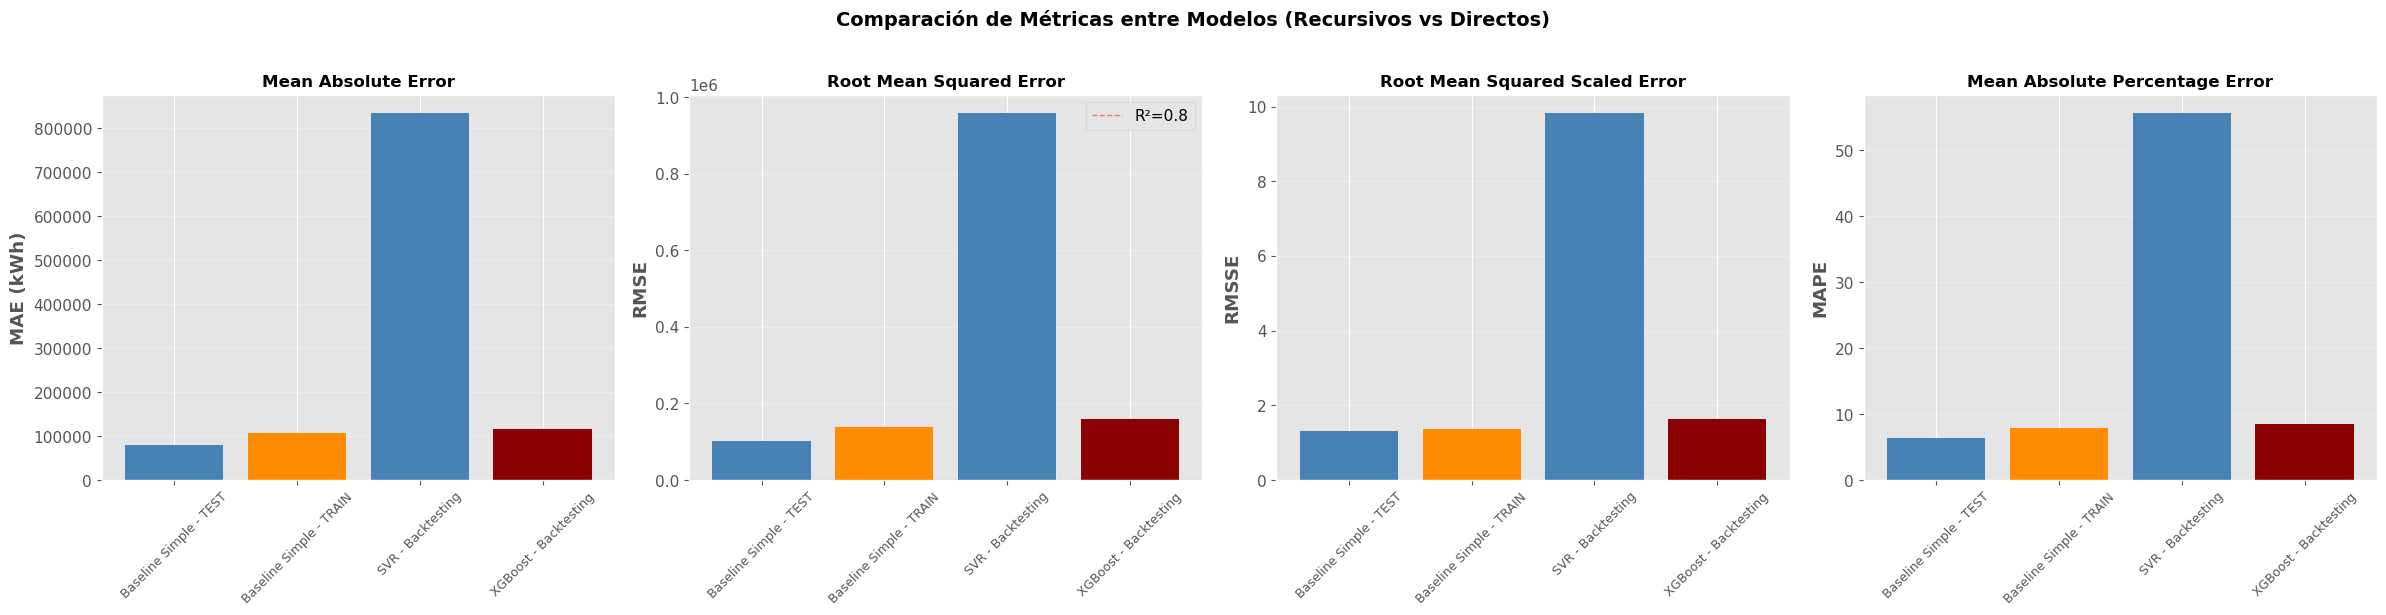

In [ ]:
# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Colores para cada modelo (ahora tenemos 7 modelos)
colors = ['steelblue', 'darkorange', 'lightcoral', 'green', 'lime', 'crimson', 'darkred']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors[:len(df_resultados)])
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=9)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['RMSE'], color=colors[:len(df_resultados)])
axes[1].set_ylabel('RMSE', fontweight='bold')
axes[1].set_title('Root Mean Squared Error', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=9)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors[:len(df_resultados)])
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45, labelsize=9)
axes[2].grid(axis='y', alpha=0.3)

# MAPE
axes[3].bar(df_resultados['Modelo'], df_resultados['MAPE'], color=colors[:len(df_resultados)])
axes[3].set_ylabel('MAPE', fontweight='bold')
axes[3].set_title('Mean Absolute Percentage Error', fontweight='bold', fontsize=12)
axes[3].tick_params(axis='x', rotation=45, labelsize=9)
axes[3].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos (Recursivos vs Directos)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## Uso de IA Generativa <a class="anchor" id="genia"></a>


**Prompt**: En base a un dataframe con las siguientes columnas Modelo, MAE, R2 y RMSSE, crea una visualización con diagrama de barras de los distintos errores, por modelo. 
Además crea una tabla con los valores ordenados por RMSSE para ver que modelo funciona mejor.

```Python

print("\n📈 GRÁFICA COMPARATIVA DE MÉTRICAS:")

# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colores para cada modelo
colors = ['steelblue', 'darkorange', 'green', 'crimson']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors)
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['R²'], color=colors)
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('Coeficiente de Determinación', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors)
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


print("\nTABLA DE RESULTADOS (ordenado por RMSSE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_rmsse = df_resultados[df_resultados['Modelo'] == 'LightGBM Baseline']['RMSSE'].values[0]
mejor_rmsse = df_resultados.iloc[0]['RMSSE']
mejora = ((baseline_rmsse - mejor_rmsse) / baseline_rmsse) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en RMSSE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSSE'], cmap='RdYlGn_r')
                          .background_gradient(subset=['R²'], cmap='RdYlGn')
                          .format({'MAE': '{:.3f}', 'R²': '{:.4f}', 'RMSSE': '{:.4f}'}))
```
**Prompt**: Crea una gráfica para mostrar los resultados de predicción del siguiente modelo:
prediccion_inicial = baseline_forecaster.predict(steps=HORIZONTE, levels=TARGET)
con HORIZONTE=7 y TARGET = Energía total (kWh). Ten en cuenta que quiero mostrar los 30 días anteriores a la predicción y el resultado predicho y el resultado original. Calcula tambien el MAE, RMSSE y R2.

**Consideraciones**: El código se tuvo  que adaptar, principalmente nombres de variales y accesos a diccionraios
```Python
# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colores para cada modelo
colors = ['steelblue', 'darkorange', 'green', 'crimson']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors)
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['R²'], color=colors)
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('Coeficiente de Determinación', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors)
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# Visualizar la predicción
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar últimos 30 días de entrenamiento
ultimos_dias_train = train[TARGET].iloc[-30:]
ax.plot(ultimos_dias_train.index, ultimos_dias_train, 
        'o-', color='steelblue', label='Entrenamiento (últimos 30 días)', 
        linewidth=2, markersize=5)

# Mostrar primeros 7 días de test (valores reales)
primeros_dias_test = test[TARGET].iloc[:HORIZONTE]
ax.plot(primeros_dias_test.index, primeros_dias_test, 
        'o-', color='orangered', label='Valores reales (test)', 
        linewidth=2, markersize=6)

# Mostrar predicción del baseline
ax.plot(prediccion_inicial.index, prediccion_inicial.value, 
        's--', color='green', label='Predicción LightGBM Baseline', 
        linewidth=2, markersize=5, alpha=0.8)

# Área sombreada para el error
ax.fill_between(primeros_dias_test.index, 
                primeros_dias_test, 
                prediccion_inicial.value,
                alpha=0.2, color='gray', label='Error de predicción')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía total (kWh)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicción del Modelo Baseline - Horizonte de {HORIZONTE} días', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular métricas básicas de esta predicción inicial
mae_inicial = mean_absolute_error(primeros_dias_test, prediccion_inicial['pred'])

scale = np.mean(np.diff(primeros_dias_test)**2)
mse = mean_squared_error(primeros_dias_test, prediccion_inicial['pred'])
rmsse_inicial = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
r2_inicial = r2_score(primeros_dias_test, prediccion_inicial['pred'])

print(f"\nMétricas de la predicción inicial (primeros {HORIZONTE} días):")
print(f"  • MAE  = {mae_inicial:.3f} kW")
print(f"  • RMSSE = {rmsse_inicial:.3f} kW")
print(f"  • R²   = {r2_inicial:.4f}")

```


## Entorno de Ejecución <a class="anchor" id="entorno"></a>

In [ ]:
import sklearn
sklearn.show_versions()

In [ ]:
from sinfo import sinfo

sinfo()

Resultado Recursivo previo con Emisiones y sin usar el lag de hace un año

<style type="text/css">
#T_22f64_row0_col1, #T_22f64_row0_col2, #T_22f64_row0_col3, #T_22f64_row1_col1, #T_22f64_row1_col2, #T_22f64_row1_col3, #T_22f64_row2_col1, #T_22f64_row2_col2 {
  background-color: #006837;
  color: #f1f1f1;
}
#T_22f64_row2_col3 {
  background-color: #016a38;
  color: #f1f1f1;
}
#T_22f64_row3_col1, #T_22f64_row3_col2, #T_22f64_row3_col3 {
  background-color: #a50026;
  color: #f1f1f1;
}
</style>
<table id="T_22f64">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_22f64_level0_col0" class="col_heading level0 col0" >Modelo</th>
      <th id="T_22f64_level0_col1" class="col_heading level0 col1" >MAE</th>
      <th id="T_22f64_level0_col2" class="col_heading level0 col2" >R²</th>
      <th id="T_22f64_level0_col3" class="col_heading level0 col3" >RMSSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_22f64_level0_row0" class="row_heading level0 row0" >3</th>
      <td id="T_22f64_row0_col0" class="data row0 col0" >Support Vector Regression</td>
      <td id="T_22f64_row0_col1" class="data row0 col1" >117703.017</td>
      <td id="T_22f64_row0_col2" class="data row0 col2" >0.8942</td>
      <td id="T_22f64_row0_col3" class="data row0 col3" >1.5751</td>
    </tr>
    <tr>
      <th id="T_22f64_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_22f64_row1_col0" class="data row1 col0" >XGBoost</td>
      <td id="T_22f64_row1_col1" class="data row1 col1" >113668.079</td>
      <td id="T_22f64_row1_col2" class="data row1 col2" >0.8914</td>
      <td id="T_22f64_row1_col3" class="data row1 col3" >1.5954</td>
    </tr>
    <tr>
      <th id="T_22f64_level0_row2" class="row_heading level0 row2" >1</th>
      <td id="T_22f64_row2_col0" class="data row2 col0" >Random Forest</td>
      <td id="T_22f64_row2_col1" class="data row2 col1" >117840.469</td>
      <td id="T_22f64_row2_col2" class="data row2 col2" >0.8869</td>
      <td id="T_22f64_row2_col3" class="data row2 col3" >1.6279</td>
    </tr>
    <tr>
      <th id="T_22f64_level0_row3" class="row_heading level0 row3" >0</th>
      <td id="T_22f64_row3_col0" class="data row3 col0" >LightGBM Baseline</td>
      <td id="T_22f64_row3_col1" class="data row3 col1" >1382502.186</td>
      <td id="T_22f64_row3_col2" class="data row3 col2" >-8.5619</td>
      <td id="T_22f64_row3_col3" class="data row3 col3" >14.9712</td>
    </tr>
  </tbody>
</table>

Resultado recursivo previo sin emisiones y con el lags [1,2,3,4,5,6,7,365]

<style type="text/css">
#T_2c916_row0_col1, #T_2c916_row0_col2, #T_2c916_row0_col3, #T_2c916_row1_col2, #T_2c916_row1_col3, #T_2c916_row2_col2 {
  background-color: #006837;
  color: #f1f1f1;
}
#T_2c916_row1_col1 {
  background-color: #016a38;
  color: #f1f1f1;
}
#T_2c916_row2_col1, #T_2c916_row2_col3 {
  background-color: #026c39;
  color: #f1f1f1;
}
#T_2c916_row3_col1, #T_2c916_row3_col2, #T_2c916_row3_col3 {
  background-color: #a50026;
  color: #f1f1f1;
}
</style>
<table id="T_2c916">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_2c916_level0_col0" class="col_heading level0 col0" >Modelo</th>
      <th id="T_2c916_level0_col1" class="col_heading level0 col1" >MAE</th>
      <th id="T_2c916_level0_col2" class="col_heading level0 col2" >R²</th>
      <th id="T_2c916_level0_col3" class="col_heading level0 col3" >RMSSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_2c916_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_2c916_row0_col0" class="data row0 col0" >Random Forest</td>
      <td id="T_2c916_row0_col1" class="data row0 col1" >112091.915</td>
      <td id="T_2c916_row0_col2" class="data row0 col2" >0.8969</td>
      <td id="T_2c916_row0_col3" class="data row0 col3" >1.5545</td>
    </tr>
    <tr>
      <th id="T_2c916_level0_row1" class="row_heading level0 row1" >3</th>
      <td id="T_2c916_row1_col0" class="data row1 col0" >Support Vector Regression</td>
      <td id="T_2c916_row1_col1" class="data row1 col1" >117655.759</td>
      <td id="T_2c916_row1_col2" class="data row1 col2" >0.8963</td>
      <td id="T_2c916_row1_col3" class="data row1 col3" >1.5589</td>
    </tr>
    <tr>
      <th id="T_2c916_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_2c916_row2_col0" class="data row2 col0" >XGBoost</td>
      <td id="T_2c916_row2_col1" class="data row2 col1" >123646.833</td>
      <td id="T_2c916_row2_col2" class="data row2 col2" >0.8799</td>
      <td id="T_2c916_row2_col3" class="data row2 col3" >1.6781</td>
    </tr>
    <tr>
      <th id="T_2c916_level0_row3" class="row_heading level0 row3" >0</th>
      <td id="T_2c916_row3_col0" class="data row3 col0" >LightGBM Baseline</td>
      <td id="T_2c916_row3_col1" class="data row3 col1" >1382502.186</td>
      <td id="T_2c916_row3_col2" class="data row3 col2" >-8.5619</td>
      <td id="T_2c916_row3_col3" class="data row3 col3" >14.9712</td>
    </tr>
  </tbody>
</table>

Resultados recursivo y directo con varios lags [1..7, 365],[1..14, 365],[1..21, 365]

<style type="text/css">
#T_407fa_row0_col1, #T_407fa_row4_col1 {
  background-color: #016a38;
  color: #f1f1f1;
}
#T_407fa_row0_col2, #T_407fa_row0_col3, #T_407fa_row1_col1, #T_407fa_row1_col2, #T_407fa_row1_col3, #T_407fa_row2_col1, #T_407fa_row2_col2, #T_407fa_row2_col3, #T_407fa_row3_col1, #T_407fa_row3_col2, #T_407fa_row3_col3, #T_407fa_row4_col2, #T_407fa_row4_col3, #T_407fa_row5_col2 {
  background-color: #006837;
  color: #f1f1f1;
}
#T_407fa_row5_col1 {
  background-color: #04703b;
  color: #f1f1f1;
}
#T_407fa_row5_col3 {
  background-color: #036e3a;
  color: #f1f1f1;
}
#T_407fa_row6_col1, #T_407fa_row6_col2, #T_407fa_row6_col3 {
  background-color: #a50026;
  color: #f1f1f1;
}
</style>
<table id="T_407fa">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_407fa_level0_col0" class="col_heading level0 col0" >Modelo</th>
      <th id="T_407fa_level0_col1" class="col_heading level0 col1" >MAE</th>
      <th id="T_407fa_level0_col2" class="col_heading level0 col2" >R²</th>
      <th id="T_407fa_level0_col3" class="col_heading level0 col3" >RMSSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_407fa_level0_row0" class="row_heading level0 row0" >6</th>
      <td id="T_407fa_row0_col0" class="data row0 col0" >Support Vector Regression (Directo)</td>
      <td id="T_407fa_row0_col1" class="data row0 col1" >116446.240</td>
      <td id="T_407fa_row0_col2" class="data row0 col2" >0.8990</td>
      <td id="T_407fa_row0_col3" class="data row0 col3" >1.5385</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row1" class="row_heading level0 row1" >3</th>
      <td id="T_407fa_row1_col0" class="data row1 col0" >XGBoost (Recursivo)</td>
      <td id="T_407fa_row1_col1" class="data row1 col1" >110924.292</td>
      <td id="T_407fa_row1_col2" class="data row1 col2" >0.8987</td>
      <td id="T_407fa_row1_col3" class="data row1 col3" >1.5409</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row2" class="row_heading level0 row2" >5</th>
      <td id="T_407fa_row2_col0" class="data row2 col0" >Support Vector Regression (Recursivo)</td>
      <td id="T_407fa_row2_col1" class="data row2 col1" >115647.635</td>
      <td id="T_407fa_row2_col2" class="data row2 col2" >0.8983</td>
      <td id="T_407fa_row2_col3" class="data row2 col3" >1.5439</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row3" class="row_heading level0 row3" >1</th>
      <td id="T_407fa_row3_col0" class="data row3 col0" >Random Forest (Recursivo)</td>
      <td id="T_407fa_row3_col1" class="data row3 col1" >112091.915</td>
      <td id="T_407fa_row3_col2" class="data row3 col2" >0.8969</td>
      <td id="T_407fa_row3_col3" class="data row3 col3" >1.5545</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row4" class="row_heading level0 row4" >2</th>
      <td id="T_407fa_row4_col0" class="data row4 col0" >Random Forest (Directo)</td>
      <td id="T_407fa_row4_col1" class="data row4 col1" >120211.642</td>
      <td id="T_407fa_row4_col2" class="data row4 col2" >0.8922</td>
      <td id="T_407fa_row4_col3" class="data row4 col3" >1.5899</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row5" class="row_heading level0 row5" >4</th>
      <td id="T_407fa_row5_col0" class="data row5 col0" >XGBoost (Directo)</td>
      <td id="T_407fa_row5_col1" class="data row5 col1" >131325.082</td>
      <td id="T_407fa_row5_col2" class="data row5 col2" >0.8703</td>
      <td id="T_407fa_row5_col3" class="data row5 col3" >1.7433</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row6" class="row_heading level0 row6" >0</th>
      <td id="T_407fa_row6_col0" class="data row6 col0" >LightGBM Baseline</td>
      <td id="T_407fa_row6_col1" class="data row6 col1" >1382502.186</td>
      <td id="T_407fa_row6_col2" class="data row6 col2" >-8.5619</td>
      <td id="T_407fa_row6_col3" class="data row6 col3" >14.9712</td>
    </tr>
  </tbody>
</table>

- DONE: Solo recursivo 
- DONE: Métricas MAE, RMSE, RMSSE, MAPE
- DONE: Grid de lags [7,30,183,365,[1,2,3,4,5,6,7,359,360,361,362,363,364,365]]
- DONE: Modelo baseline sencillo con media con día anterior y mismo día hace un año, para el siguiente día la media del día que acabas de predecir y el mismo dia del año anterior así hasta el horizonte 7.
- DONE: ver caracteristicas-Lags más importantes
- TODO: Predicciones desglosadas por días y medir error con una función custom h+1..h+7

DIA,   0,     1,          2,     3,    4,    5,    6,    7,
   ,x1.1,  x1.2,   x1.3    , x1.4 , x1.5, x1.6, x1.7, 
           x2.1,   x2.2    , x2.3 , x2.4, x2.5, x2.6, x2.7,

errorHorizonteH1 = mean (X_.1)
errorHorizonteH2 = mean (X_.2)
errorHorizonteH3 = mean (X_.3)
errorHorizonteH4 = mean (X_.4)
errorHorizonteH5 = mean (X_.5)
errorHorizonteH6 = mean (X_.6)
errorHorizonteH7 = mean (X_.7)            